<a href="https://colab.research.google.com/github/SvetlanaErmakova/Analytics-and-statistics/blob/main/taxi_drivers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

По данным о такси-компании изучим отток водителей и посмотрим, какие есть различия между водителями, которые покидают сервис, и которые остаются.

1) Сформулируем и протестируем гипотезы, выделим группы водителей, которые наиболее подвержены "оттоку".

2) На основе результатов сделаем выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения.

(хи-квадрат - оцениваем связь меж 2мя номинативными переменными. Аналог ти-теста если зависимая перемнная является категорией. Ранговые непраметрические тесты)

Также:

1.	Проверим, есть ли различия в размерах оттока клиентов в разных городах (churn, city)

2.	Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)

3.	Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)


Описание данных:

•	city – город

•	phone – основное устройство, которое использует водитель

•	signup_date – дата регистрации аккаунта (YYYYMMDD)

•	last_trip_date – дата последней поездки (YYYYMMDD)

•	avg_dist – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации

•	avg_rating_by_driver – средняя оценка поездок водителем

•	avg_rating_of_driver – средняя оценка поездок водителя

•	surge_pct – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)

•	avg_surge – средний множитель всплеска за все поездки этого водителя

•	trips_in_first_30_days – количество поездок, которые совершил водитель в первые 30 дней после регистрации

•	luxury_car_user – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль

•	weekday_pct – процент поездок пользователя, совершенных в будние дни


In [ ]:
!pip install pingouin
!pip install scikit_posthocs

In [ ]:
import numpy as np
import pandas as pd

import scipy.stats as ss
import seaborn as sns
import scikit_posthocs as sp #попарные сравнения для непараметрических тестов
import pingouin as pg

sns.set(rc = {'figure.figsize': (12, 6)}, style = "whitegrid")

In [ ]:
churn = pd.read_csv("churn.csv")

In [ ]:
churn.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [ ]:
churn.dtypes

,0
avg_dist,float64
avg_rating_by_driver,float64
avg_rating_of_driver,float64
avg_surge,float64
city,object
last_trip_date,object
phone,object
signup_date,object
surge_pct,float64
trips_in_first_30_days,int64


In [ ]:
churn.isna().sum()

,0
avg_dist,0
avg_rating_by_driver,201
avg_rating_of_driver,8122
avg_surge,0
city,0
last_trip_date,0
phone,396
signup_date,0
surge_pct,0
trips_in_first_30_days,0


## Готовим данные

Создаем лейбл churn – пользователь ушел, если не был активен последние 30 дней (но можно попробовать и другие значения в зависимости от компании/данных)

In [ ]:
churn.last_trip_date

,last_trip_date
0,2014-06-17
1,2014-05-05
2,2014-01-07
3,2014-06-29
4,2014-03-15
...,...
49995,2014-06-05
49996,2014-01-25
49997,2014-05-22
49998,2014-01-15


In [ ]:
churn.last_trip_date = pd.to_datetime(churn.last_trip_date)
churn.signup_date = pd.to_datetime(churn.signup_date)

#посчитаем колво дней которое водители не появлялись в нашем приложении с самого ближайшего дня в данных
churn['days_since_last_trip'] = churn.last_trip_date.max() - churn.last_trip_date


In [ ]:
churn.dtypes

,0
avg_dist,float64
avg_rating_by_driver,float64
avg_rating_of_driver,float64
avg_surge,float64
city,object
last_trip_date,datetime64[ns]
phone,object
signup_date,datetime64[ns]
surge_pct,float64
trips_in_first_30_days,int64


In [ ]:
churn['days_since_last_trip']

,days_since_last_trip
0,14 days
1,57 days
2,175 days
3,2 days
4,108 days
...,...
49995,26 days
49996,157 days
49997,40 days
49998,167 days


In [ ]:
# извлекаем количество дней из объектов типа datetime
churn['days_since_last_trip'] = churn['days_since_last_trip'].dt.days
churn['days_since_last_trip']

,days_since_last_trip
0,14
1,57
2,175
3,2
4,108
...,...
49995,26
49996,157
49997,40
49998,167


Считаем, что водитель ушел, если он не появлялся 30 дней. (зависит от данных и целей)

In [ ]:
churn['churn'] = churn.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')

In [ ]:
churn[['days_since_last_trip', 'churn']]

,days_since_last_trip,churn
0,14,not_churn
1,57,churn
2,175,churn
3,2,not_churn
4,108,churn
...,...,...
49995,26,not_churn
49996,157,churn
49997,40,churn
49998,167,churn


##1. Проверим, есть ли различия в размерах оттока клиентов в разных городах (churn, city)

In [ ]:
pd.crosstab(churn.churn, churn.city) #cводная табличка

city,Astapor,King's Landing,Winterfell
churn,,,
churn,12306,3767,15123
not_churn,4228,6363,8213


In [ ]:
ss.chi2_contingency(pd.crosstab(churn.churn, churn.city))

Chi2ContingencyResult(statistic=3821.5510225559633, pvalue=0.0, dof=2, expected_freq=array([[10315.89328,  6320.3096 , 14559.79712],
       [ 6218.10672,  3809.6904 ,  8776.20288]]))

In [ ]:
pg.chi2_independence(churn, "churn", "city") #в пингвине

(city           Astapor  King's Landing   Winterfell
 churn                                              
 churn      10315.89328       6320.3096  14559.79712
 not_churn   6218.10672       3809.6904   8776.20288,
 city       Astapor  King's Landing  Winterfell
 churn                                         
 churn        12306            3767       15123
 not_churn     4228            6363        8213,
                  test    lambda         chi2  dof  pval    cramer  power
 0             pearson  1.000000  3821.551023  2.0   0.0  0.276462    1.0
 1        cressie-read  0.666667  3788.042430  2.0   0.0  0.275247    1.0
 2      log-likelihood  0.000000  3767.315031  2.0   0.0  0.274493    1.0
 3       freeman-tukey -0.500000  3791.421829  2.0   0.0  0.275370    1.0
 4  mod-log-likelihood -1.000000  3849.643594  2.0   0.0  0.277476    1.0
 5              neyman -2.000000  4073.406300  2.0   0.0  0.285426    1.0)

Получается, что мы не принимаем Н0, кт заключалась в том что различий нет. Те категориальные переменные churn и city свяязаны.

##2. Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)

Проверим на нормальность:




In [ ]:
pg.normality(churn, "trips_in_first_30_days", "city", method = "normaltest")

,W,pval,normal
city,,,
King's Landing,12011.013892,0.0,False
Astapor,18186.739338,0.0,False
Winterfell,21390.545655,0.0,False


<Axes: xlabel='trips_in_first_30_days', ylabel='Count'>

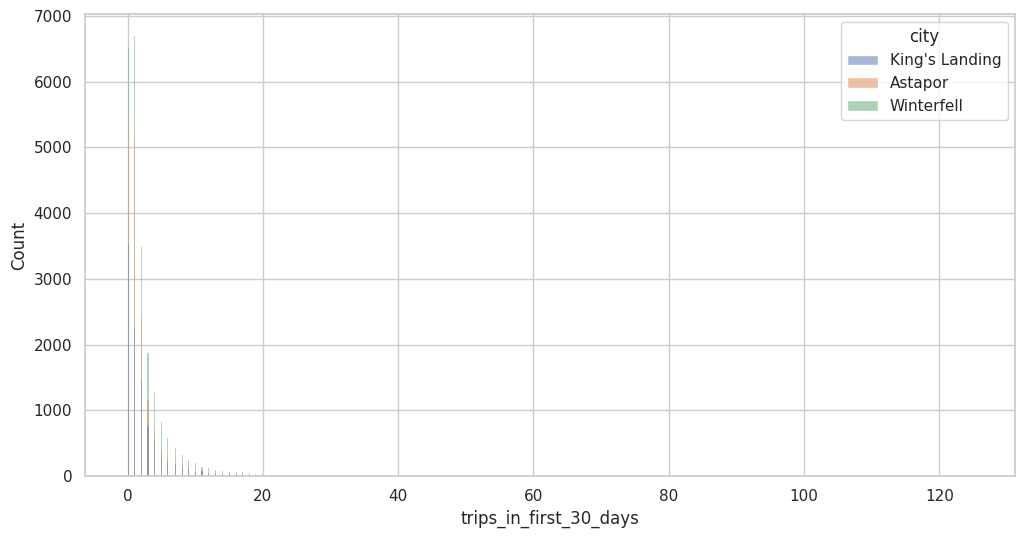

In [ ]:
sns.histplot(data = churn, x = "trips_in_first_30_days", hue = "city")

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

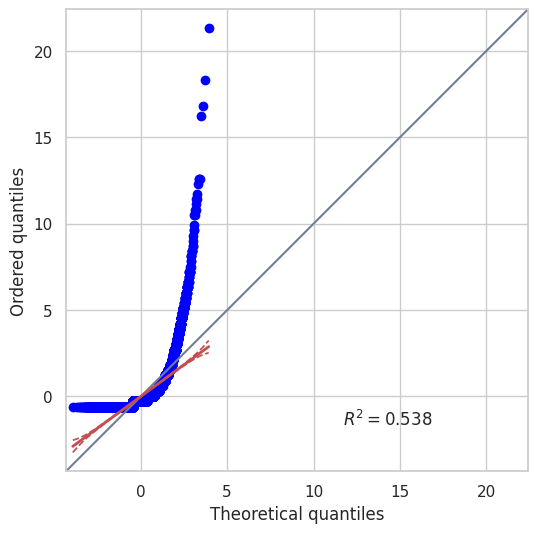

In [ ]:
pg.qqplot(churn.query("city == 'Astapor'").trips_in_first_30_days)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

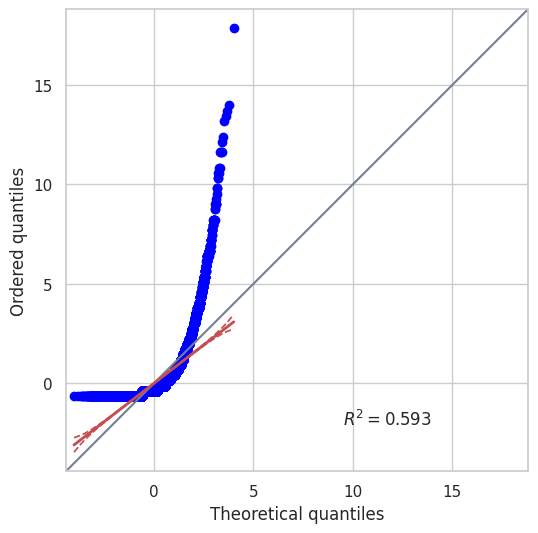

In [ ]:
pg.qqplot(churn.query("city == 'Winterfell'").trips_in_first_30_days)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

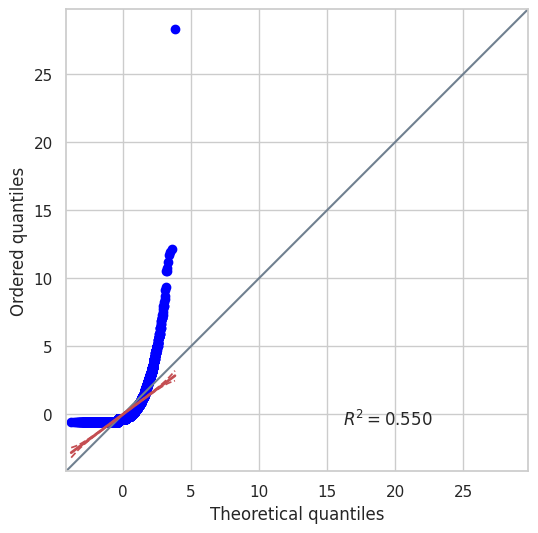

In [ ]:
pg.qqplot(churn[churn.city == "King's Landing"].trips_in_first_30_days)

Распределения не нормальные, значит воспользуемся непараметрическим аналогом ANOVA: критерий красколла уоллиса (или могли сделать лог преобразование)

In [ ]:
ss.kruskal(churn.query("city == 'Astapor'").trips_in_first_30_days,
           churn.query("city == 'Winterfell'").trips_in_first_30_days,
           churn[churn.city == "King's Landing"].trips_in_first_30_days)

KruskalResult(statistic=221.32105325320535, pvalue=8.724567791804361e-49)

In [ ]:
pg.kruskal(data = churn, dv = "trips_in_first_30_days", between = "city")

,Source,ddof1,H,p-unc
Kruskal,city,2,221.321053,8.724568e-49


Различия есть, проведем попарные сравнения

In [ ]:
sp.posthoc_dunn(a = churn, val_col = "trips_in_first_30_days", group_col = "city", p_adjust = "holm")

,Astapor,King's Landing,Winterfell
Astapor,1.000000e+00,1.313616e-09,2.448501e-49
King's Landing,1.313616e-09,1.000000e+00,8.440212e-10
Winterfell,2.448501e-49,8.440212e-10,1.000000e+00


Посмотрим как и в каких городах различаются поездки:

<Axes: xlabel='city', ylabel='trips_in_first_30_days'>

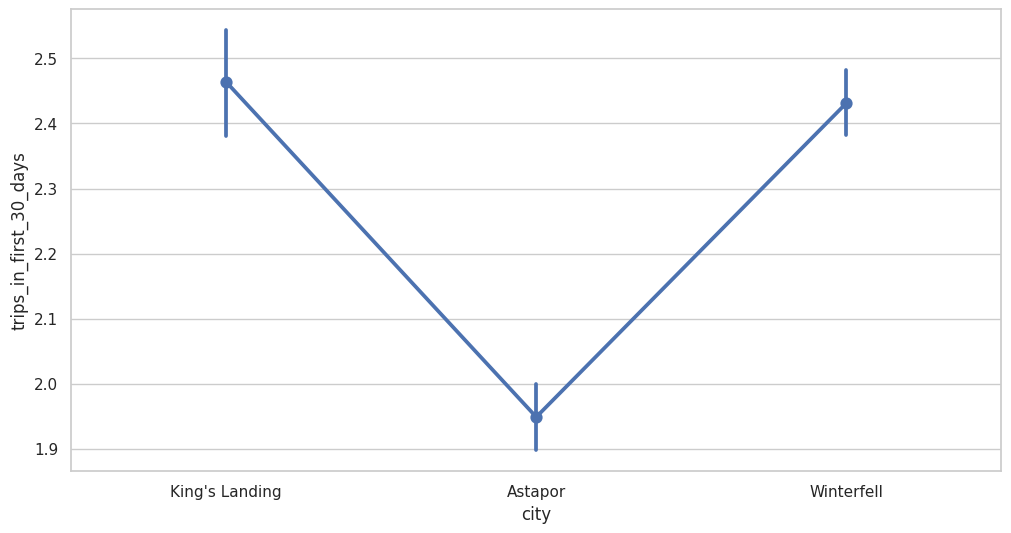

In [ ]:
sns.pointplot(data = churn, x = "city", y = "trips_in_first_30_days")

In [ ]:
churn.groupby("city").trips_in_first_30_days.describe()

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
Astapor,16534.0,1.948651,3.333600,0.0,0.0,1.0,2.0,73.0
King's Landing,10130.0,2.463672,4.326140,0.0,0.0,1.0,3.0,125.0
Winterfell,23336.0,2.431179,3.835147,0.0,0.0,1.0,3.0,71.0


##3.	Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)

In [ ]:
ss.mannwhitneyu(churn.query("churn == 'churn'").trips_in_first_30_days,
                churn.query("churn == 'not_churn'").trips_in_first_30_days)

MannwhitneyuResult(statistic=234767452.0, pvalue=0.0)

Различия статистически значимы, те кто ушел в среднем делают меньше поездок чем те кто не ушел

In [ ]:
churn.groupby("churn").trips_in_first_30_days.describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
churn,31196.0,1.658482,2.654222,0.0,0.0,1.0,2.0,73.0
not_churn,18804.0,3.306318,4.986743,0.0,0.0,2.0,4.0,125.0


Значимые различия есть, ушедшие пользователи были менее активны.